# 기존 코드 오류 기록지

## 1. MASE 산출 코드 오류

In [2]:
import os
import glob
import gc

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

from transformers import PatchTSTForPrediction

from datasets import Dataset

In [3]:
data = "coin"

output_dir = "saved_models"
log_dir = os.path.join('logstf', data)

os.makedirs(log_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok = True)

loss_name = "MASE"

learning_rate = 5e-5
num_train_epochs = 400

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
## target domain
target_X = pd.read_csv(f"../data/{data}/train_input_7.csv").iloc[:, 1:].values.astype(np.float32)

np.random.seed(2)
random_indices1 = np.random.choice(pd.read_csv("../data/M4_train.csv").iloc[:, (1):].index,
                                   size=target_X.shape[0] * 20, replace=True)

X_data = pd.read_csv("../data/M4_train.csv").iloc[:, 1 + (24 * 0):].loc[random_indices1].values.astype(np.float32)
y_data = pd.read_csv("../data/M4_test.csv").iloc[:, 1:].loc[random_indices1].values.astype(np.float32)

## bootstrap
np.random.seed(42)
select = np.random.choice(len(X_data), size=len(X_data), replace=True)
X_bootstrap = X_data[select]
y_bootstrap = y_data[select]

val_split_index = int(len(X_bootstrap) * 0.8)

def to_tensor_and_reshape(array):
    result = torch.tensor(array)
    result = result.reshape(-1, result.shape[1], 1)

    return result

X_train, X_valid = to_tensor_and_reshape(X_bootstrap[:val_split_index]), to_tensor_and_reshape(X_bootstrap[val_split_index:])
y_train, y_valid = to_tensor_and_reshape(y_bootstrap[:val_split_index]), to_tensor_and_reshape(y_bootstrap[val_split_index:])

## setting dataloader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 256, shuffle = True, num_workers = 16)

test_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 256, num_workers = 16)

In [5]:
from tensorflow.keras.losses import Loss
import tensorflow as tf

class MASE(Loss):
    def __init__(self, training_data, period, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.scale = self.calculate_scale(training_data, period)    ## 스케일 고정???

    def seasonal_diff(self, data, period):
        return data[period:] - data[:-period]

    def calculate_scale(self, training_data, period):
        diff = self.seasonal_diff(training_data, period)
        scale = np.mean(np.abs(diff))
        return scale

    def call(self, y_true, y_pred):
        y_pred = tf.reshape(y_pred, tf.shape(y_true))
        error = tf.abs(y_true - y_pred)
        return tf.reduce_mean(error / self.scale)

In [6]:
y_train = y_train.numpy()
y_train = tf.convert_to_tensor(y_train)

I0000 00:00:1762222315.389742 2236009 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 55994 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB MIG 7g.80gb, pci bus id: 0000:47:00.0, compute capability: 8.0


In [7]:
y_train.shape, y_train[y_train.shape[1]:].shape

(TensorShape([11568, 24, 1]), TensorShape([11544, 24, 1]))

In [8]:
np.mean(np.abs(y_train[y_train.shape[1]:] - y_train[:-y_train.shape[1]]))

np.float32(3665.8032)

In [9]:
mase = MASE(y_train, y_train.shape[1])
mase.scale

np.float32(3665.8032)

> 해당 코드는 시점 간 차이가 아닌 서로 다른 시퀀스 간 차이를 계산함. 잘못된 구현.

## 2. train/valid/test dataset의 분포 차이

In [6]:
import matplotlib.pyplot as plt

In [7]:
## target domain
target_X = pd.read_csv(f"../data/{data}/train_input_7.csv").iloc[:, 1:].values.astype(np.float32)
target_y = pd.read_csv(f"../data/{data}/train_output_7.csv").iloc[:, 1:].values.astype(np.float32)

target_X_val = target_X[-round(target_X.shape[0] * 0.2):, :].astype(np.float32)
target_y_val = target_y[-round(target_y.shape[0] * 0.2):].astype(np.float32)
target_X = target_X[:-round(target_X.shape[0] * 0.2), :].astype(np.float32)
target_y = target_y[:-round(target_y.shape[0] * 0.2)].astype(np.float32)

test_X  = pd.read_csv(f"../data/{data}/val_input_7.csv").iloc[:, 1:].values.astype(np.float32)
test_y  = pd.read_csv(f"../data/{data}/val_output_7.csv").iloc[:, 1:].values.astype(np.float32)

In [9]:
np.mean(target_y), np.mean(target_y_val), np.mean(test_y)

(np.float32(151.20018), np.float32(67.18279), np.float32(75.756134))

In [8]:
np.median(target_y), np.median(target_y_val), np.median(test_y)

(np.float32(148.55), np.float32(60.955), np.float32(73.27))

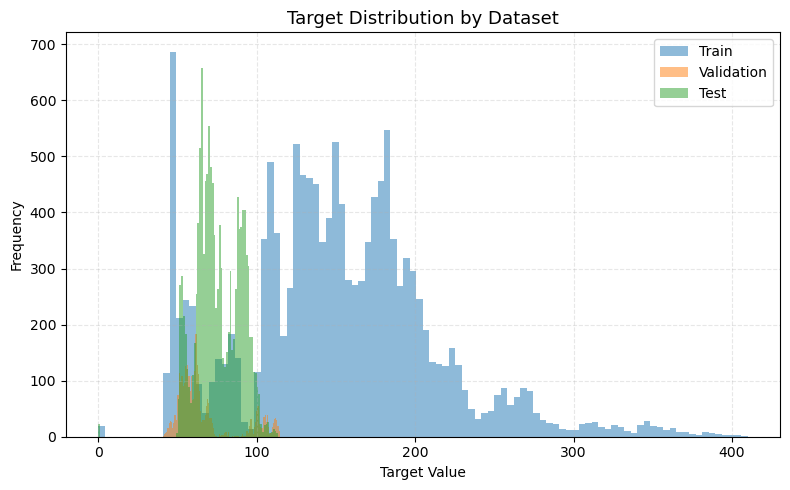

In [47]:
plt.figure(figsize=(8, 5))
plt.hist(target_y.reshape(-1), bins=100, alpha=0.5, label='Train', color='tab:blue', edgecolor='none')
plt.hist(target_y_val.reshape(-1), bins=100, alpha=0.5, label='Validation', color='tab:orange', edgecolor='none')
plt.hist(test_y.reshape(-1), bins=100, alpha=0.5, label='Test', color='tab:green', edgecolor='none')

plt.title('Target Distribution by Dataset', fontsize=13)
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

> 분포가 다름이 명확함. 샘플링 과정에서 랜덤 샘플링이 아닌 특정 지점에서 샘플링한 것의 여파인듯.

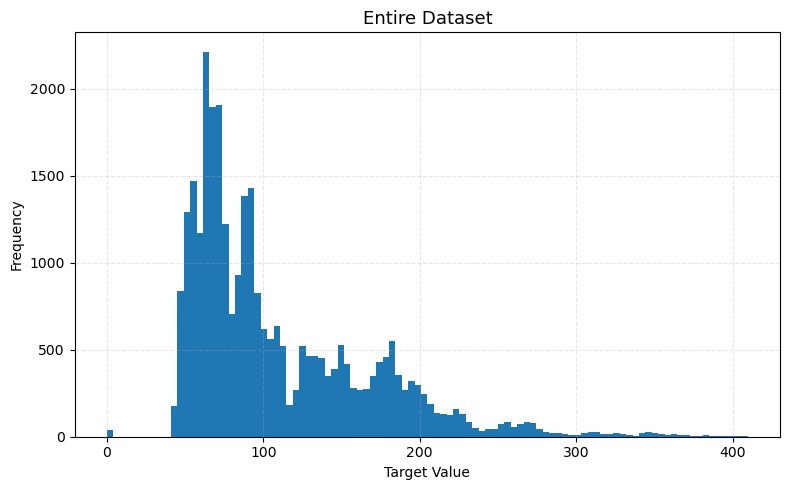

In [48]:
plt.figure(figsize=(8, 5))

plt.hist(np.concat([target_y.reshape(-1), target_y_val.reshape(-1), test_y.reshape(-1)]), bins = 100)
plt.title('Entire Dataset', fontsize=13)
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

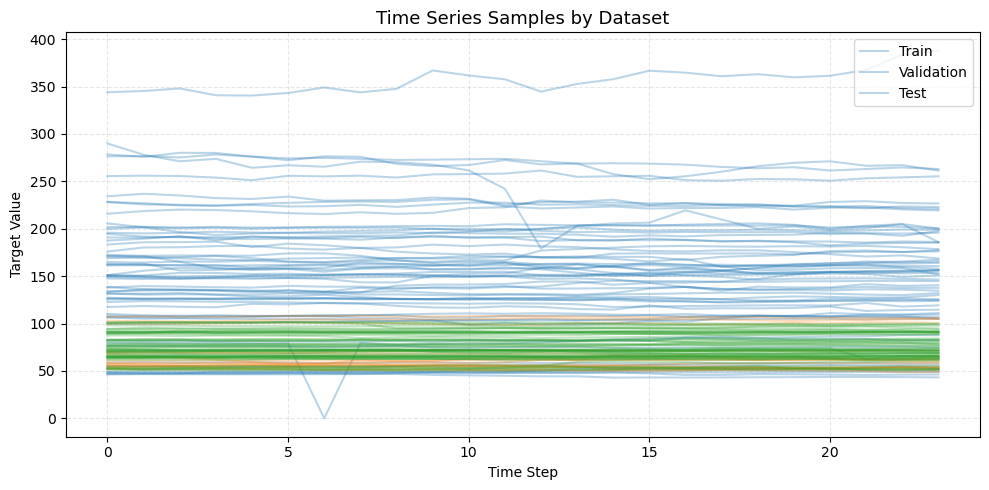

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))

# 각각의 시계열을 전부 플롯 (투명도 조절)
for seq in target_y[::10]:
    plt.plot(seq, color='tab:blue', alpha=0.3)
for seq in target_y_val[::10]:
    plt.plot(seq, color='tab:orange', alpha=0.3)
for seq in test_y[::10]:
    plt.plot(seq, color='tab:green', alpha=0.3)

plt.title('Time Series Samples by Dataset', fontsize=13)
plt.xlabel('Time Step')
plt.ylabel('Target Value')
plt.legend(['Train', 'Validation', 'Test'])
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## 3. MAPE와 이상치

> 0인 값이 있어서 MAPE로 최적화 시 문제점 많음. 이상치인데 손실 측정에 영향을 많이 줌
>
> 추가적인 처리 또는 손실에서 배제하는 것이 바람직할 듯.